In [101]:
import matplotlib.pyplot as plt

import os, PIL, random, pathlib

import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(1)

In [103]:
data_dir = 'captcha'
data_dir = pathlib.Path(data_dir)

all_image_paths = list(data_dir.glob('*')) # 获取所有图片的路径
all_image_paths = [str(path) for path in all_image_paths] # 转换为字符列表

random.shuffle(all_image_paths) # 随机打乱顺序

all_label_names = [os.path.splitext(os.path.basename(path))[0] for path in all_image_paths] # 提取标签(文件名即为标签)

image_count = len(all_image_paths) # 图片总数
print('图片总数为: ', image_count)

图片总数为:  1070


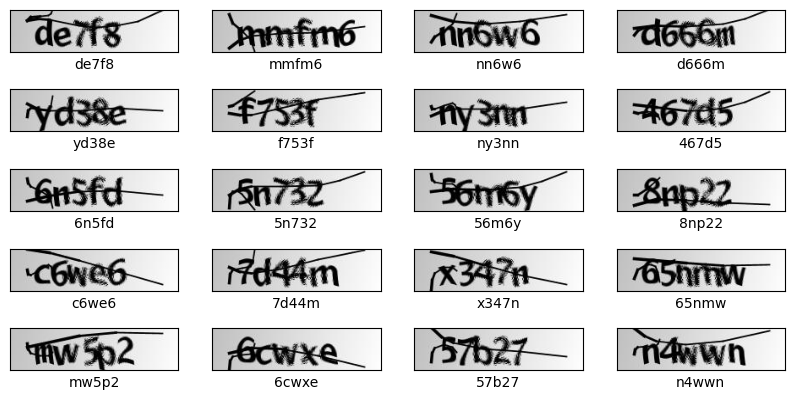

In [105]:
# 图形可视化
plt.figure(figsize=(10, 5))

for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    images = plt.imread(all_image_paths[i]) # 读取并加载指定路径的图像文件
    plt.imshow(images)

    plt.xlabel(all_label_names[i])

plt.show()

In [107]:
# 标签数字化

# 定义字符集
number = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
char_set = number + alphabet
char_set_len = len(char_set)
label_name_len = len(all_label_names[0]) # 每个验证码的长度(5个字符)

# 将文本标签转换为独热编码向量
def text2vec(text):
    vector = np.zeros([label_name_len, char_set_len])
    for i, c in enumerate(text):
        idx = char_set.index(c)
        vector[i][idx] = 1.0 # 对应位置设为1
    return vector

all_labels = [text2vec(i) for i in all_label_names] # 所有标签向量化

In [109]:
# 图像预处理
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=1) # 以灰度图读取
    image = tf.image.resize(image, [50, 200]) # 统一尺寸
    return image/255.0 # 归一化

def load_and_preprocess_image(path):
    image = tf.io.read_file(path) # 读取文件
    return preprocess_image(image) # 预处理

In [111]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # 自动优化参数

# 创建数据集
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(all_labels)

# 合并图像和标签
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<_ZipDataset element_spec=(TensorSpec(shape=(50, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(5, 36), dtype=tf.float64, name=None))>

In [113]:
# 划分训练集(1000)和验证集(70)
train_ds = image_label_ds.take(1000)
val_ds = image_label_ds.skip(1000)

In [115]:
# 批处理和性能优化
BATCH_SIZE= 16
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 50, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5, 36), dtype=tf.float64, name=None))>

In [117]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential([
    layers.Reshape((50, 200, 1), input_shape=(None, 50, 200, 1)), # 输入层 将输入从(batch, sequence, height, width, channels)-->(batch, height, width, channels)

    # 特征提取
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 分类器
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),

    # 输出层 (5str * 36class)
    layers.Dense(label_name_len * char_set_len),
    layers.Reshape([label_name_len, char_set_len]),
    layers.Softmax() # 多分类输出
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_7 (Reshape)             │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 48, 198, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 22, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 11, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 33792)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1000)           │    33,793,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 180)            │       180,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 5, 36)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_4 (Softmax)             │ (None, 5, 36)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,991,996 (129.67 MB)

 Trainable params: 33,991,996 (129.67 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # 多分类交叉熵
              metrics=['accuracy'])

In [121]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.1644 - loss: 2.8843 - val_accuracy: 0.3686 - val_loss: 2.1468
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.6688 - loss: 1.1834 - val_accuracy: 0.6286 - val_loss: 1.3301
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.8900 - loss: 0.3738 - val_accuracy: 0.7314 - val_loss: 1.0524
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.9556 - loss: 0.1492 - val_accuracy: 0.6886 - val_loss: 1.4380
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.9746 - loss: 0.0868 - val_accuracy: 0.7000 - val_loss: 1.1939
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9858 - loss: 0.0523 - val_accuracy: 0.7800 - val_loss: 0.9528
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.9926 - loss: 0.0269 - val_accuracy: 0.7800 - val_loss: 1.0361
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.9966 - loss: 0.0124 - val_accura

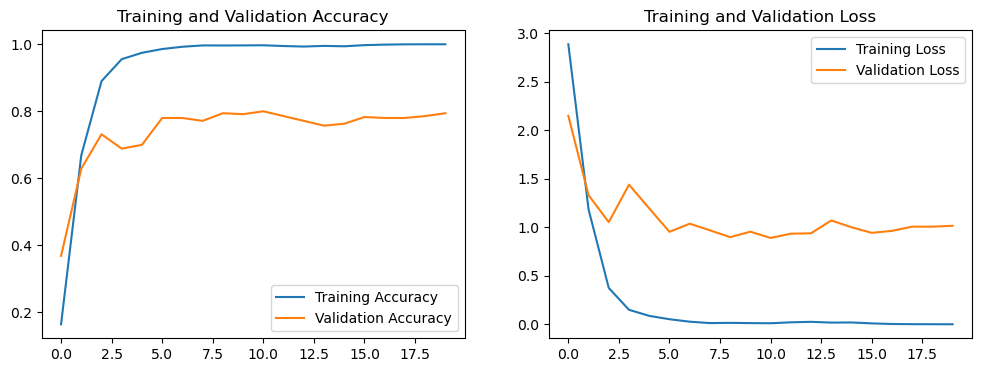

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [123]:
model.save('validation_code.h5')

new_model = tf.keras.models.load_model('validation_code.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


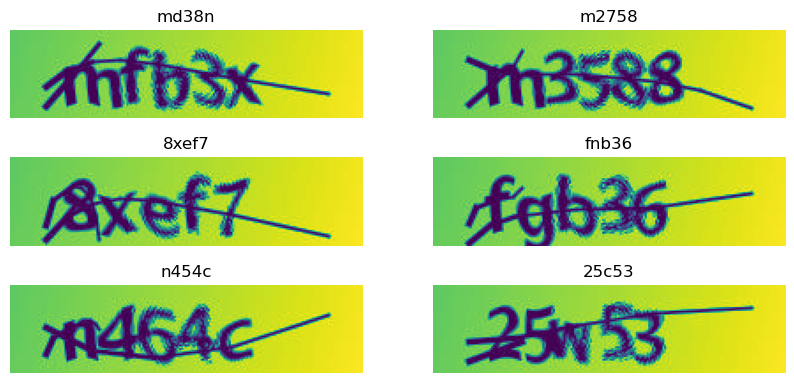

In [129]:
def vec2text(vec):
    '''
    还原标签(向量->字符串)
    '''
    text = []
    for i, c in enumerate(vec):
        text.append(char_set[c])
    return ''.join(text)

plt.figure(figsize=(10, 8))

for images, labels in val_ds.take(1):
    for i in range(6):
        ax = plt.subplot(5, 2, i+1)
        plt.imshow(images[i])

        img_array = tf.expand_dims(images[i], 0)

        predictions = model.predict(img_array) # 3D tensor:(batch_size, 5, 36) batch_size=预测的图片数量 5=每个字符(共5个)概率分布列表的行数 36=每个字符位置的概率分布
        # 设置标题
        plt.title(vec2text(np.argmax(predictions, axis=2)[0])) # 在第3个维度上取最大值索引

        plt.axis('off')